#6.1 오토인코더 기초

- 레이블이 없이 특징을 추출하는 신경망
- 인코더 : 층 마다 뉴런을 줄여가면서 **의미의 압축**을 시킴
- 디코더 : 층 마다 뉴런을 늘리면서 (입력의 뉴런수와 동일하게) **복원**시킴

#6.2 오토인코더로 이미지의 특징 추출하기

##6.2.1 오토인코더 구현

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [2]:
# 하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


###데이터셋 활용

- 훈련 데이터셋만 활용..

In [3]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



###모델 생성

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        #인코더..
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            #의미의 압축
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축합니다
        )
        #디코더..
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            #입력크기만큼 늘리기..
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력합니다
        )

    #인코딩 결과 (압축본), 디코딩 결과 (복원본) 모두 return..
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

###모델 객체 생성

- nn.MSELoss()
    : 같은 크기의 행렬에 대한 원소별 차이 제곱합

- Adam() 
    - SGD의 변형함수
    - 학습중인 기울기를 참고하여 학습속도를 자동으로 변화시킴

In [5]:
#모델 객체
autoencoder = Autoencoder().to(DEVICE)
#최적화함수 객체
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)

#행렬 오차제곱합
criterion = nn.MSELoss()

In [6]:
# 원본 이미지를 시각화 하기 (첫번째 열)
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.  #0~1사이의 값으로 만듦..

###학습함수

In [7]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

###모델 학습 및 시각화

[Epoch 1]


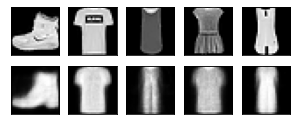

[Epoch 2]


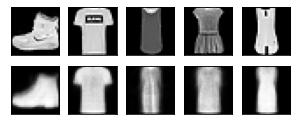

[Epoch 3]


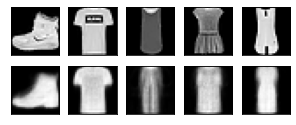

[Epoch 4]


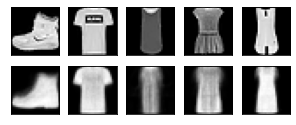

[Epoch 5]


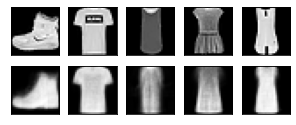

[Epoch 6]


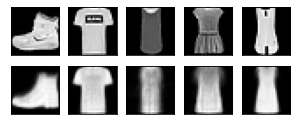

[Epoch 7]


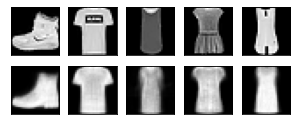

[Epoch 8]


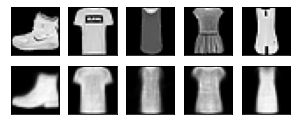

[Epoch 9]


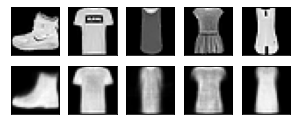

[Epoch 10]


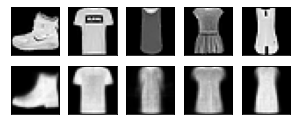

In [8]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    # 디코더에서 나온 이미지를 시각화 하기 (두번째 열)
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)   #복원값..

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28))    #원본
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))  #복원본
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

#6.2.2 잠재 변수 들여다보기

In [9]:
# 잠재변수를 3D 플롯으로 시각화
view_data = trainset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

In [10]:
#종류별 딕셔너리
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

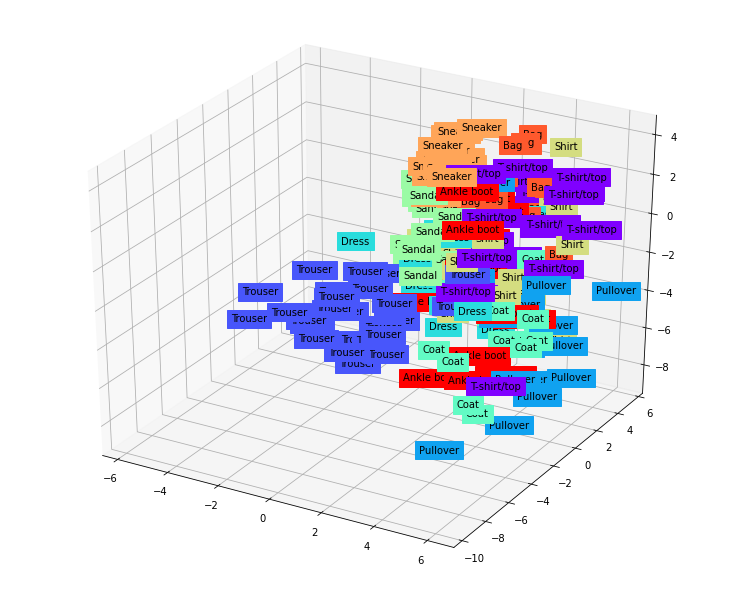

In [11]:
#실제 시각화!
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

#잠재변수의 각 차원을 X, Y, Z 로 받아옴..
X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

#범위 지정..
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

**결과 분석**

- 실제로 비슷한 레이블끼리 모여있는 모습을 확인 할 수 있다.

#6.3 오토인코더로 망가진 이미지 복원하기

##6.3.1 잡음 제거 오토인코더 구현

In [12]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import numpy as np

In [13]:
# 하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cpu


###데이터 불러오기

In [14]:
# Fashion MNIST 학습 데이터셋
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

###모델 생성

- 6.2와 동일..

In [15]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축합니다
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력합니다
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

###모델 객체 생성

In [16]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

###잡음 추가 함수 생성

In [17]:
def add_noise(img):
    #임의로 0.2 잡음 강도 지정
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [18]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        #유일한 차이!
        noisy_x = add_noise(x)  # 입력에 노이즈 더하기
        
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)

        label = label.to(DEVICE)
        encoded, decoded = autoencoder(noisy_x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
    return avg_loss / len(train_loader)

In [19]:
#학습..
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))
    # 이번 예제에선 학습시 시각화를 건너 뜁니다

[Epoch 1] loss:0.03937328297859316
[Epoch 2] loss:0.028578417645747475
[Epoch 3] loss:0.025377601949073104
[Epoch 4] loss:0.024316562895676984
[Epoch 5] loss:0.023816337703721227
[Epoch 6] loss:0.02351358863932174
[Epoch 7] loss:0.023103882328295376
[Epoch 8] loss:0.023116392659337154
[Epoch 9] loss:0.023250681056237933
[Epoch 10] loss:0.02311160592342427


##6.3.2 잡음 제거 시각화하기

In [20]:
#테스트세트 가져오기..
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

# 테스트샘플 한개..
sample_data = testset.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.


original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)  #잡음 추가
_, recovered_x = autoencoder(noisy_x)

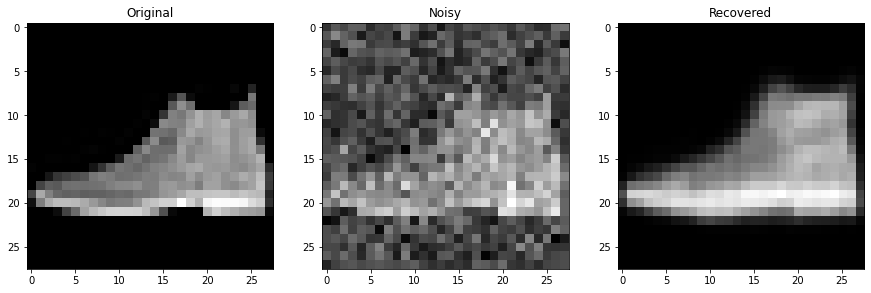

In [21]:
f, a = plt.subplots(1, 3, figsize=(15, 15))

#넘파이 행렬변환..
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# 원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# 오염된 원본 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# 복원된 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()